# Import Required Libraries

Import necessary libraries such as geopandas, numpy, and matplotlib.


In [4]:
# Import Required Libraries
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from rasterio.features import rasterize
from PIL import Image

In [5]:
road = np.array(Image.open("./vegetations.png", "r"))

# Load GeoJSON File

Load a GeoJSON file into a GeoDataFrame using geopandas.read_file().


In [20]:
# Load GeoJSON File
GEOJSON_PATH = "/media/noan/USB2/Poznan_Internship/Data/surface_buildings.geojson"
gdf = gpd.read_file(GEOJSON_PATH)
gdf.head()

,id,geom,object_id,type,type_id,material,color,baf,a [m2],user,subzone,measurement_date,species,species_latin,height_m,habitat,geometry
0,660.0,010600002081080000010000000103000000010000000A...,NULL,NULL,NULL,asphalt,NULL,0.0,41.08,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428584.508 5808263.127, 64285..."
1,658.0,0106000020810800000100000001030000000100000005...,NULL,NULL,NULL,concrete_cobblestone,NULL,0.3,32.34,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428622.622 5808319.326, 64286..."
2,657.0,0106000020810800000100000001030000000100000004...,NULL,NULL,NULL,concrete_cobblestone,NULL,0.3,5.68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428584.444 5808267.735, 64286..."
3,656.0,010600002081080000010000000103000000010000000C...,NULL,NULL,NULL,asphalt,NULL,0.0,875.98,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428584.092 5808293.156, 64285..."
4,750.0,010600002081080000010000000103000000010000000A...,NULL,NULL,NULL,asphalt,NULL,0.0,41.08,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428584.508 5808263.127, 64285..."


# Convert GeoDataFrame to Desired CRS

Convert the GeoDataFrame to a specific coordinate reference system (CRS) using the to_crs() method.


In [21]:
# Convert GeoDataFrame to Desired CRS
TARGET_CRS = "EPSG:3857"  # Web Mercator projection
gdf = gdf.to_crs(TARGET_CRS)
gdf.head()

,id,geom,object_id,type,type_id,material,color,baf,a [m2],user,subzone,measurement_date,species,species_latin,height_m,habitat,geometry
0,660.0,010600002081080000010000000103000000010000000A...,NULL,NULL,NULL,asphalt,NULL,0.0,41.08,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1886931.567 6873333.967, 18869..."
1,658.0,0106000020810800000100000001030000000100000005...,NULL,NULL,NULL,concrete_cobblestone,NULL,0.3,32.34,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1886992.569 6873427.017, 18869..."
2,657.0,0106000020810800000100000001030000000100000004...,NULL,NULL,NULL,concrete_cobblestone,NULL,0.3,5.68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1886931.354 6873341.52, 188697..."
3,656.0,010600002081080000010000000103000000010000000C...,NULL,NULL,NULL,asphalt,NULL,0.0,875.98,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1886930.175 6873383.192, 18869..."
4,750.0,010600002081080000010000000103000000010000000A...,NULL,NULL,NULL,asphalt,NULL,0.0,41.08,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1886931.567 6873333.967, 18869..."


# Extract Geometry Bounds

Extract the minimum and maximum bounds of the geometries in the GeoDataFrame to define the mask dimensions.


In [22]:
# Extract Geometry Bounds
min_x, min_y, max_x, max_y = gdf.total_bounds
print(f"Bounds: Min ({min_x}, {min_y}), Max ({max_x}, {max_y})")

Bounds: Min (1886928.0440916228, 6873013.859118296), Max (1887576.5933432663, 6873475.558560872)


# Generate Mask from GeoDataFrame

Create a binary mask by rasterizing the GeoDataFrame geometries onto a numpy array.


In [23]:
# Generate Mask from GeoDataFrame
# resolution = 1  # Define resolution of the mask
# width = int((max_x - min_x) / resolution)
# height = int((max_y - min_y) / resolution)

[height, width, _] = road.shape

# Create an affine transformation for the raster
transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, width, height)

# Rasterize the geometries
shapes = ((geom, 1) for geom in gdf.geometry)
mask = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype=np.uint8)

print(f"Generated mask with dimensions: {mask.shape}")

Generated mask with dimensions: (1096, 1565)


# Visualize Mask and GeoDataFrame

Use matplotlib to overlay the GeoDataFrame on top of the generated mask for visualization.


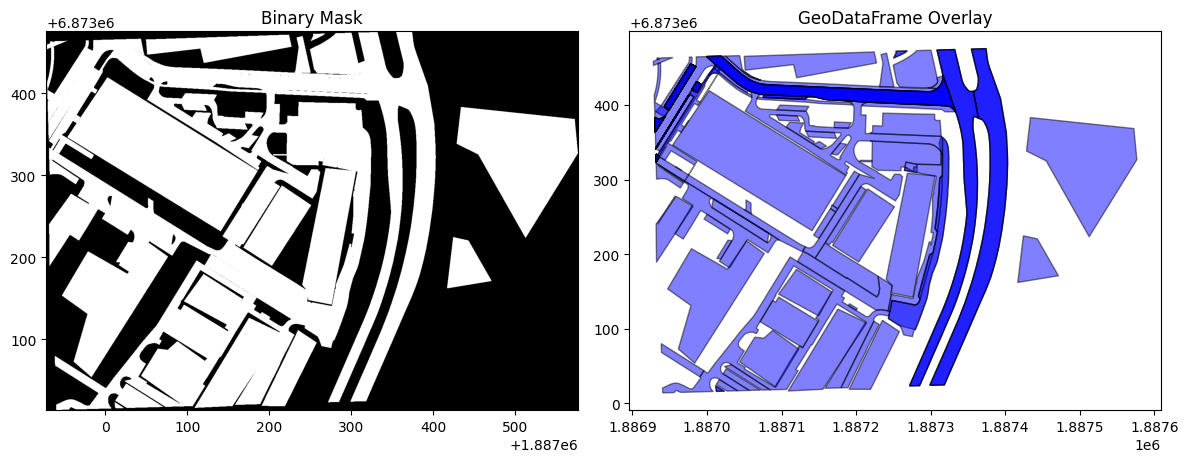

In [24]:
# Visualize Mask and GeoDataFrame
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the binary mask
ax[0].imshow(mask, cmap="gray", extent=(min_x, max_x, min_y, max_y))
ax[0].set_title("Binary Mask")

# Plot the GeoDataFrame
gdf.plot(ax=ax[1], color="blue", alpha=0.5, edgecolor="black")
ax[1].set_title("GeoDataFrame Overlay")

plt.tight_layout()
plt.show()

In [25]:
# Save the binary mask to an image file
from PIL import Image

# Convert the mask to an image (scale to 255 for better visualization)
mask_image = Image.fromarray(mask * 255)
mask_image.save("building_mask_binary.png")

print("Binary mask saved as 'binary_mask.png'")

Binary mask saved as 'binary_mask.png'


In [26]:
from image_similarity_measures.evaluate import evaluation

metrics = ["rmse"]

print(
    "Buildings:", 
    evaluation(org_img_path="./building_mask_binary.png", pred_img_path="./buildings_bin.png", metrics=metrics)
)

Buildings: {'rmse': 0.03599242866039276}
